# PBO learnt on several iterations and one weigth one the car on hill environment

## Define parameters

In [74]:
%load_ext autoreload
%autoreload 2

import numpy as np
import jax
import jax.numpy as jnp

# keys
seed = 0
key = jax.random.PRNGKey(seed)
shuffle_key, q_network_key, random_weights_key, pbo_network_key = jax.random.split(key, 4)

# Sample collection
n_states_x = 10
n_states_v = 10
n_actions = 2
n_samples = n_states_x * n_states_v * n_actions
gamma = 0.9

# # Weights collection
n_weights = 1

# # Trainings
layers_dimension = (10,)
max_bellman_iterations = 15
batch_size_samples = n_samples

# ## Linear PBO
training_steps = 100
fitting_steps = 10
batch_size_weights = n_weights
learning_rate = {"first": 0.001, "last": 0.00005, "duration": training_steps * fitting_steps * n_samples // batch_size_samples}

# ## Q-learning
fitting_steps_q = fitting_steps * training_steps
learning_rate_q = {"first": 0.01, "last": 0.005, "duration": fitting_steps_q * n_samples // batch_size_samples}

# # Visualisation of errors and performances
max_bellman_iterations_validation = max_bellman_iterations + 20
horizon = 50

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define environment

In [2]:
from pbo.environment.car_on_hill import CarOnHillEnv

max_pos = 1.0
max_velocity = 3.0

states_x = jnp.linspace(-max_pos, max_pos, n_states_x)
boxes_x_size = (2 * max_pos) / (n_states_x - 1)
states_x_boxes = (np.linspace(-max_pos, max_pos + boxes_x_size, n_states_x + 1) - boxes_x_size / 2)
states_v = jnp.linspace(-max_velocity, max_velocity, n_states_v)
boxes_v_size = (2 * max_velocity) / (n_states_v - 1)
states_v_boxes = (np.linspace(-max_velocity, max_velocity + boxes_v_size, n_states_v + 1) - boxes_v_size / 2)


env = CarOnHillEnv(max_pos, max_velocity, gamma)

## Collect samples

### Samples on the mesh

In [3]:
from pbo.sample_collection.replay_buffer import ReplayBuffer


replay_buffer = ReplayBuffer()

n_samples = n_states_x * n_states_v * n_actions

for state_x in states_x:
    for state_v in states_v:
        state = jnp.array([state_x, state_v])
        
        for action in jnp.arange(n_actions):
            env.reset(state)
            next_state, reward, _, _ = env.step(jnp.array([action]))

            replay_buffer.add(state, jnp.array([action]), reward, next_state)

replay_buffer.cast_to_jax_array()

### Visualize samples

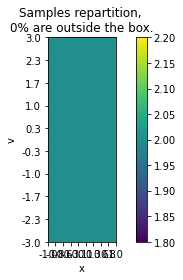

In [4]:
from pbo.sample_collection.count_samples import count_samples
from pbo.utils.two_dimesions_mesh import TwoDimesionsMesh


samples_count, n_outside_boxes = count_samples(replay_buffer.states[:, 0], replay_buffer.states[:, 1], states_x_boxes, states_v_boxes)
samples_visu_mesh = TwoDimesionsMesh(states_x, states_v, sleeping_time=0)

samples_visu_mesh.set_values(samples_count, zeros_to_nan=True)
samples_visu_mesh.show(
    f"Samples repartition, \n{int(100 * n_outside_boxes / n_samples)}% are outside the box.", xlabel="x", ylabel="v"
)

## Optimal Q function

  0%|          | 0/80 [00:00<?, ?it/s]

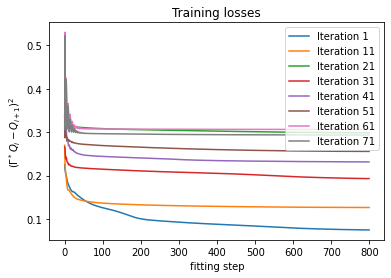

In [5]:
import matplotlib.pyplot as plt 
from tqdm.notebook import tqdm

from pbo.sample_collection.dataloader import SampleDataLoader
from pbo.networks.learnable_q import FullyConnectedQ


max_bellman_iterations_optimal = 80
fitting_steps_q_optimal = 800

data_loader_samples = SampleDataLoader(replay_buffer, n_samples, shuffle_key)
q_optimal = FullyConnectedQ(
    state_dim=2,
    action_dim=1,
    continuous_actions=False,
    n_actions_on_max=n_actions,
    action_range_on_max=None,
    gamma=gamma,
    network_key=q_network_key,
    random_weights_range=None,
    random_weights_key=random_weights_key,
    learning_rate={"first": 0.01, "last": 0.0005, "duration": fitting_steps_q_optimal},
    layers_dimension=layers_dimension,
    zero_initializer=True,
)

l2_losses = np.ones((max_bellman_iterations_optimal, fitting_steps_q_optimal)) * np.nan

for bellman_iteration in tqdm(range(max_bellman_iterations_optimal)):
    params_target = q_optimal.params
    q_optimal.reset_optimizer()

    for step in range(fitting_steps_q_optimal):
        cumulative_l2_loss = 0
        
        data_loader_samples.shuffle()
        for batch_samples in data_loader_samples:
            q_optimal.params, q_optimal.optimizer_state, l2_loss = q_optimal.learn_on_batch(q_optimal.params, params_target, q_optimal.optimizer_state, batch_samples)
            cumulative_l2_loss += l2_loss

        l2_losses[bellman_iteration, step] = cumulative_l2_loss


for bellman_iteration in range(0, max_bellman_iterations_optimal, 10):
    plt.plot(l2_losses[bellman_iteration], label=f"Iteration {bellman_iteration + 1}")

plt.legend()
plt.xlabel("fitting step")
plt.ylabel(r"$(\Gamma^*Q_i - Q_{i +  1})^2$")
plt.title("Training losses")
plt.show()

In [6]:
env.simulate(q_optimal, horizon, jnp.array([-0.5, 0]))

[-0.5  0. ]
[2.4480896]
[2.0973034]

[-0.5196691 -0.3866922]
[2.835473]
[2.495514]

[-0.57458174 -0.69058496]
[3.1263828]
[2.8473854]

[-0.6524237  -0.83584255]
[3.1444855]
[3.0304604]

[-0.73584473 -0.8066418 ]
[2.9898577]
[3.0737934]

[-0.77940965 -0.07043047]
[2.847269]
[2.8773737]

[-0.75013524  0.6601439 ]
[2.475646]
[2.6205206]

[-0.64621395  1.4185476 ]
[1.7443733]
[2.2109118]

[-0.47197494  1.9924439 ]
[1.3932304]
[3.1669455]

[-0.26982018  1.9430188 ]
[2.2507944]
[2.914527]

[-0.09581636  1.5163397 ]
[2.0734205]
[3.6263866]

[0.03389191 1.1175563 ]
[1.6494131]
[3.6977196]

[0.13404922 0.89555955]
[1.4338293]
[3.6776037]

[0.214388   0.71707237]
[1.2352276]
[3.5250807]

[0.27873483 0.5769776 ]
[1.0860596]
[3.3802423]

[0.33132216 0.4828008 ]
[0.9986372]
[3.4703684]

[0.37691316 0.43707395]
[0.9800701]
[4.0403605]

[0.42033547 0.4393423 ]
[1.0682707]
[5.331051]

[0.4663898  0.48992503]
[1.4869576]
[6.9622974]

[0.52000034 0.5909258 ]
[3.3515835]
[7.933813]

[0.5863459  0.7449882

DeviceArray([ True], dtype=bool)

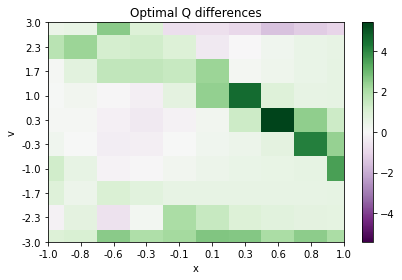

In [7]:
optimal_diff_q = env.diff_q_mesh(q_optimal, states_x, states_v)

q_visu_mesh = TwoDimesionsMesh(states_x, states_v, sleeping_time=0, axis_equal=False, zero_centered=True)

q_visu_mesh.set_values(optimal_diff_q)
q_visu_mesh.show("Optimal Q differences", xlabel="x", ylabel="v")

## Train Q with Fitted-Q

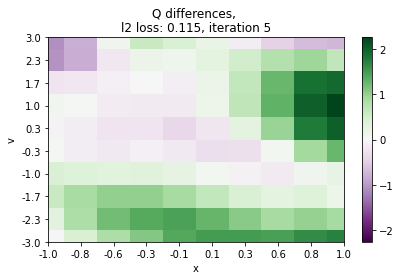

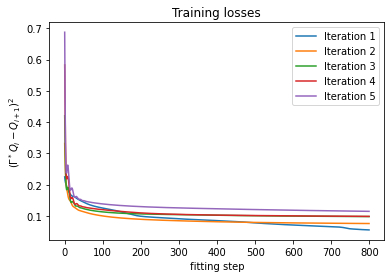

In [26]:
import matplotlib.pyplot as plt 
from tqdm.notebook import tqdm

from pbo.sample_collection.dataloader import SampleDataLoader
from pbo.networks.learnable_q import FullyConnectedQ


data_loader_samples = SampleDataLoader(replay_buffer, batch_size_samples, shuffle_key)
q = FullyConnectedQ(
    state_dim=2,
    action_dim=1,
    continuous_actions=False,
    n_actions_on_max=n_actions,
    action_range_on_max=None,
    gamma=gamma,
    network_key=q_network_key,
    random_weights_range=None,
    random_weights_key=random_weights_key,
    learning_rate=learning_rate_q,
    layers_dimension=layers_dimension,
    zero_initializer=True,
)
validation_initial_weight = q.to_weights(q.params)

l2_losses = np.zeros((max_bellman_iterations, fitting_steps_q))

for bellman_iteration in range(max_bellman_iterations):
    params_target = q.params
    q.reset_optimizer()

    for step in range(fitting_steps_q):
        cumulative_l2_loss = 0
        
        data_loader_samples.shuffle()
        for batch_samples in data_loader_samples:
            q.params, q.optimizer_state, l2_loss = q.learn_on_batch(q.params, params_target, q.optimizer_state, batch_samples)
            cumulative_l2_loss += l2_loss

        l2_losses[bellman_iteration, step] = cumulative_l2_loss

    diff_q = env.diff_q_mesh(q, states_x, states_v)

    q_visu_mesh.set_values(diff_q)
    q_visu_mesh.show(f"Q differences, \nl2 loss: {str(jnp.round(cumulative_l2_loss, 3))}, iteration {bellman_iteration + 1}", xlabel="x", ylabel="v")



for bellman_iteration in range(max_bellman_iterations):
    plt.plot(l2_losses[bellman_iteration], label=f"Iteration {bellman_iteration + 1}")

plt.legend()
plt.xlabel("fitting step")
plt.ylabel(r"$(\Gamma^*Q_i - Q_{i +  1})^2$")
plt.title("Training losses")
plt.show()

In [22]:
env.simulate(q, horizon, jnp.array([-0.5, 0]))

[-0.1  0. ]
[0.18525136]
[-0.1468308]

[-0.13660991 -0.74192715]
[-0.00309324]
[0.07673657]

[-0.22285771 -0.9720297 ]
[-0.06011689]
[0.24730313]

[-0.32721618 -1.0865152 ]
[0.14785635]
[0.5698205]

[-0.4326281 -0.9785168]
[0.568812]
[0.86639416]

[-0.5148534 -0.6335997]
[1.0070928]
[0.99440277]

[-0.59383845 -0.9142241 ]
[0.56805384]
[0.8150054]

[-0.6541883  -0.28470838]
[1.0590552]
[0.86210144]

[-0.6858872 -0.3390642]
[0.9252845]
[0.76095283]

[-0.7199618 -0.3327153]
[0.8086935]
[0.6556078]

[-0.75068974 -0.27436545]
[0.73089087]
[0.56919897]

[-0.77361155 -0.17931417]
[0.698171]
[0.5199684]

[-0.7858581  -0.06335983]
[0.7081405]
[0.5176667]

[-0.7860577   0.05940227]
[0.7551161]
[0.56332195]

[-0.774189    0.17579062]
[0.8318089]
[0.64880526]

[-0.75157785  0.27176264]
[0.92888796]
[0.7564558]

[-0.72104204  0.33156195]
[1.0341152]
[0.8623618]

[-0.68699116  0.3397954 ]
[1.1329511]
[0.94521177]

[-0.6551187   0.28742453]
[1.2113205]
[0.9947349]

[-0.63140154  0.1787373 ]
[1.257487

DeviceArray([False], dtype=bool)

## Collect weights

In [10]:
from pbo.weights_collection.weights_buffer import WeightsBuffer


weights_buffer = WeightsBuffer()

# Add initial validation weights
weights_buffer.add(validation_initial_weight)

# Add randow weights
q = FullyConnectedQ(
    state_dim=2,
    action_dim=1,
    continuous_actions=False,
    n_actions_on_max=n_actions,
    action_range_on_max=None,
    gamma=gamma,
    network_key=q_network_key,
    random_weights_range=None,
    random_weights_key=random_weights_key,
    learning_rate=None,
    layers_dimension=layers_dimension,
    zero_initializer=False,
)

while len(weights_buffer) < n_weights:
    weights = q.random_init_weights()
    weights_buffer.add(weights)

weights_buffer.cast_to_jax_array()

## Train linear PBO

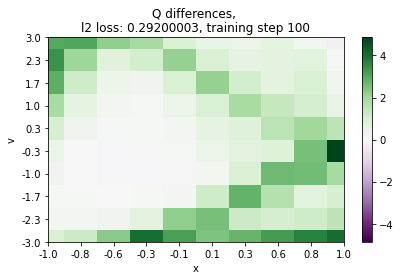

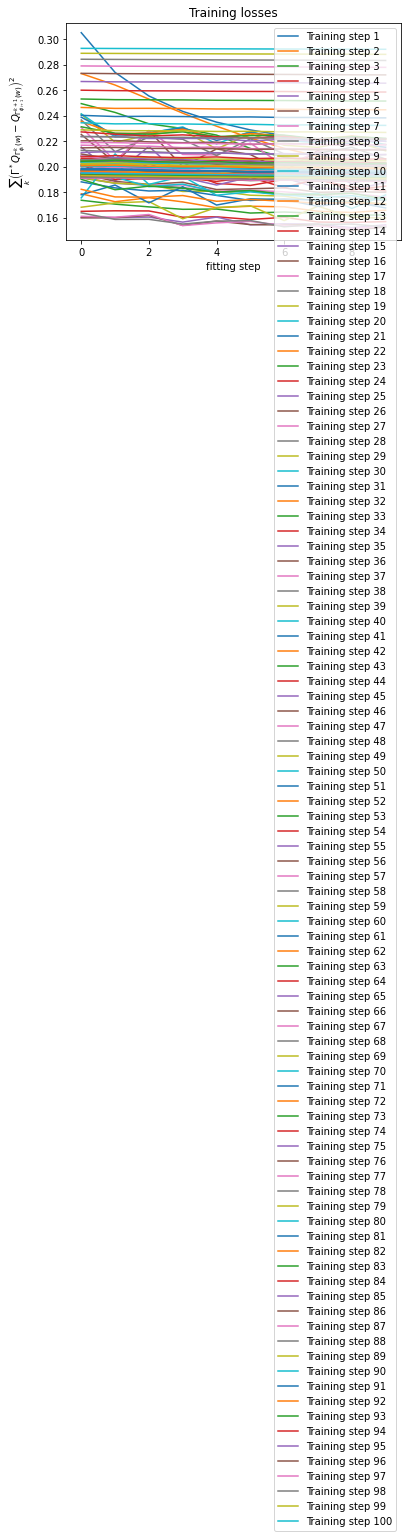

In [84]:
from tqdm.notebook import tqdm

from pbo.sample_collection.dataloader import SampleDataLoader
from pbo.weights_collection.dataloader import WeightsDataLoader
from pbo.networks.learnable_pbo import LinearPBO


data_loader_samples = SampleDataLoader(replay_buffer, batch_size_samples, shuffle_key)
data_loader_weights = WeightsDataLoader(weights_buffer, batch_size_weights, shuffle_key)
pbo = LinearPBO(q, max_bellman_iterations, False, pbo_network_key, learning_rate)  # add_infinity == False
importance_iteration = jnp.ones(max_bellman_iterations + 1)
importance_iteration = importance_iteration.at[-1].set(0)

l2_losses = np.ones((training_steps, fitting_steps)) * np.nan

for training_step in range(training_steps):
    params_target = pbo.params
    # pbo.reset_optimizer()

    for fitting_step in range(fitting_steps):
        cumulative_l2_loss = 0

        data_loader_weights.shuffle()
        for batch_weights in data_loader_weights:
            data_loader_samples.shuffle()
            for batch_samples in data_loader_samples:
                pbo.params, pbo.optimizer_state, l2_loss = pbo.learn_on_batch(
                    pbo.params, params_target, pbo.optimizer_state, batch_weights, batch_samples, importance_iteration
                )
                cumulative_l2_loss += l2_loss
        
        l2_losses[training_step, fitting_step] = cumulative_l2_loss

    q_weight = validation_initial_weight
    for _ in range(max_bellman_iterations):
        q_weight = pbo(pbo.params, q_weight)
    q.params = q.to_params(q_weight)
    diff_q = env.diff_q_mesh(q, states_x, states_v)

    q_visu_mesh.set_values(diff_q)
    q_visu_mesh.show(f"Q differences, \nl2 loss: {str(jnp.round(cumulative_l2_loss, 3))}, training step {training_step + 1}", xlabel="x", ylabel="v")


for training_step in range(0, training_steps):
    plt.plot(l2_losses[training_step], label=f"Training step {training_step + 1}")

plt.legend()
plt.xlabel("fitting step")
plt.ylabel(r"$\sum_{k} \left(\Gamma^*Q_{\Gamma_{\phi_i}^k(w)} - Q_{\Gamma_{\phi_{i + 1}}^{k + 1}(w)} \right)^2$")
plt.title("Training losses")
plt.show()

In [ ]:
for training_step in range(0, training_steps):
    plt.plot(l2_losses[training_step], label=f"Training step {training_step + 1}")

plt.legend()
plt.ylim(0, max(l2_losses[0]))
plt.xlabel("fitting step")
plt.ylabel(r"$\sum_{k} \left(\Gamma^*Q_{\Gamma_{\phi_i}^k(w)} - Q_{\Gamma_{\phi_{i + 1}}^{k + 1}(w)} \right)^2$")
plt.title("Training losses")
plt.show()

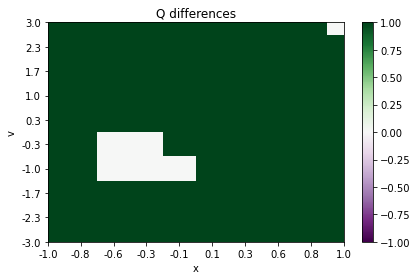

In [85]:
q_weight = validation_initial_weight
for _ in range(max_bellman_iterations):
    q_weight = pbo(pbo.params, q_weight)
q.params = q.to_params(q_weight)
diff_q = env.diff_q_mesh(q, states_x, states_v)

q_visu_mesh = TwoDimesionsMesh(states_x, states_v, sleeping_time=0, axis_equal=False, zero_centered=True)

q_visu_mesh.set_values((diff_q > 0).astype(float))
q_visu_mesh.show("Q differences", xlabel="x", ylabel="v")

In [86]:
q_weight = validation_initial_weight
for _ in range(max_bellman_iterations):
    q_weight = pbo(pbo.params, q_weight)
q.params = q.to_params(q_weight)

# q.params = q.to_params(pbo.fixed_point(pbo.params))


env.simulate(q, horizon, jnp.array([-0.5, 0]))

[-0.5  0. ]
[-0.767905]
[-0.7552788]

[-0.4803309  0.3866922]
[-0.7674191]
[-0.71207213]

[-0.4254183  0.690585 ]
[-0.72734666]
[-0.65858245]

[-0.34757635  0.83584267]
[-0.65377545]
[-0.5701287]

[-0.2641553   0.80664194]
[-0.5379293]
[-0.425287]

[-0.19029287  0.65616035]
[-0.40842032]
[-0.2602303]

[-0.13487127  0.44623253]
[-0.31523824]
[-0.14425921]

[-0.10178459  0.2134663 ]
[-0.29643607]
[-0.1268785]

[-0.09239412 -0.02605632]
[-0.35984492]
[-0.21574926]

[-0.10697368 -0.26488298]
[-0.47346377]
[-0.3767426]

[-0.14507785 -0.494572  ]
[-0.5564234]
[-0.5501387]

[-0.20496078 -0.69564986]
[-0.6107075]
[-0.6839564]

[-0.3142061 -1.4989252]
[-0.7275002]
[-0.73218083]

[-0.5013969 -2.1752536]
[-0.91954637]
[-0.749491]

[-0.6881829 -1.4923896]
[-0.72009015]
[-0.69038224]

[-0.79673713 -0.6887635 ]
[-0.6412165]
[-0.65364766]

[-0.8558869  -0.48698276]
[-0.5725844]
[-0.509434]

[-0.8677695   0.24635687]
[-0.41624284]
[-0.02270365]

[-0.80539757  1.0156133 ]
[-0.23781276]
[0.46184802]

[-

DeviceArray([ True], dtype=bool)

In [ ]:
# training_losses = np.zeros(max_bellman_iterations_validation)
# validation_losses = np.zeros(max_bellman_iterations_validation)
# absording_probabilities = np.zeros((max_bellman_iterations_validation, horizon))

# batch_iterated_weights = validation_initial_weight.reshape((1, -1))
# for bellman_iteration in range(max_bellman_iterations_validation):
#     q_i = q.discretize(batch_iterated_weights, states, actions)[0]
#     batch_iterated_weights = pbo(pbo.params, batch_iterated_weights)
#     q_i_plus_1 = q.discretize(batch_iterated_weights, states, actions)[0]
#     policy_q = q_i_plus_1.argmax(axis=1)

#     training_losses[bellman_iteration] = jnp.abs(env.apply_bellman_operator(q_i) - q_i_plus_1).mean()
#     validation_losses[bellman_iteration] = jnp.abs(optimal_q - q_i_plus_1).mean()
#     absording_probabilities[bellman_iteration] = env.absorbing_probability(policy_q, horizon)

#     print(policy_q)

## Visualize errors in Q functions

In [ ]:
import matplotlib.pyplot as plt 

iterations = range(1, max_bellman_iterations_validation + 1)

plt.plot(iterations, validation_losses, label="pbo linear", color="green")
plt.plot(iterations, validation_losses_tabular, label="pbo max-linear", color="grey", linestyle="--")
plt.plot(iterations, validation_losses_optimal, label="pbo optimal", color="black")
plt.plot(range(1, max_bellman_iterations + 1), validation_losses_q, label="FQI", color="red", linewidth=4)
plt.vlines(max_bellman_iterations, 0, np.max(validation_losses_q), color="black", linestyle="--")

plt.xticks(iterations)
plt.xlabel("iterations")

plt.title(r"$|| Q^* - Q_i ||_1$")
_ = plt.legend()

In [ ]:
plt.plot(iterations, training_losses, label="pbo linear", color="green")
plt.plot(iterations, training_losses_tabular, label="pbo max-linear", color="grey")
plt.plot(iterations, training_losses_optimal, label="pbo optimal", color="black")
plt.plot(range(1, max_bellman_iterations + 1), training_losses_q, label="FQI", color="red")
plt.vlines(max_bellman_iterations, 0, np.maximum(np.max(training_losses_q), np.max(training_losses)), color="black", linestyle="--")

plt.xticks(iterations)
plt.xlabel("iterations")

plt.title(r"$|| \Gamma^*Q_{i-1} - Q_i ||_1$")
_ = plt.legend()

## Understanding the learning process

In [ ]:
empirical_transition_proba = np.zeros((n_states, n_states * n_actions))

for idx_sample in range(len(replay_buffer.states)):
    state = replay_buffer.states[idx_sample, 0]
    action = replay_buffer.actions[idx_sample, 0]
    next_state = replay_buffer.next_states[idx_sample, 0]

    empirical_transition_proba[next_state, state * n_actions + action] += 1 

empirical_transition_proba /= n_repetitions


In [ ]:
np.linalg.norm(empirical_transition_proba - pbo_tabular.params["TabularPBONet/linear"]["w"] / gamma)

## Visualize errors in preformances

In [ ]:
iteration = 5
time = range(1, horizon + 1)


plt.plot(time, absording_probabilities[iteration], label="pbo linear", color="green")
plt.plot(time, absording_probabilities_tabular[iteration], label="pbo max-linear", color="grey", linestyle="--")
plt.plot(time, absording_probabilities_optimal[iteration], label="pbo optimal", color="black")
plt.plot(time, absording_probabilities_q[min([iteration, max_bellman_iterations - 1])], label="FQI", color="red")

plt.xticks(time)
plt.xlabel("time")

plt.title(r"$P^{\pi}(s_i =$ absorbing state)")
_ = plt.legend()

In [ ]:
iteration = 1


plt.plot(iterations, absording_probabilities[:, -1], label="pbo linear", color="green")
plt.plot(iterations, absording_probabilities_tabular[:, -1], label="pbo max-linear", color="grey", linestyle="--")
plt.plot(iterations, absording_probabilities_optimal[:, -1], label="pbo optimal", color="black")
plt.plot(range(1, max_bellman_iterations + 1), absording_probabilities_q[:, -1], label="FQI", color="red")
plt.vlines(max_bellman_iterations, 0, 1, color="black", linestyle="--")

plt.xticks(iterations)
plt.xlabel("iterations")

plt.title(r"$P^{\pi}(s_i =$ absorbing state)" + f" after {horizon} steps")
_ = plt.legend()